# CycleGAN - Horse2Zebra

---

In this notebook will learn about Generative Adversarial Networks by implementing a Cycle GAN to transfer styles from Horse to Zebra.

**Important:** Set the Cloab environment to run on GPU

Author: Ramon Planas

Based on SIMPLE GAN colab from: Albert Pumarola

In [17]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import time
import random
import torch
import itertools
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
from IPython.display import display
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1f430ae4d05a6a94707783a2a97396a2e452cc29c6356b03f7c78efbbc33d49b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 276.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    img = img[:4]
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [4]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/


for details.

--2020-04-04 15:13:13--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  20.7MB/s    in 6.1s    

2020-04-04 15:13:20 (18.1 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

In [53]:
!pip install -U -q PyDrive
#file_id = "1YE0BuojBKjQG6EjBRPP9mgGtsBwo07pe" # 1st dataset
#file_id = "10tzYgF-1-7NF7pjAS0r25eY55ZUg_SM4" # new dataset (Nuria)
file_id = "1sHe9v6ZXJ6orYH4ADPtho7F6ceR5-AGT" # new dataset 2 (Nuria)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download file
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('./datasets/barcelona2madrid.zip')

# Unzip dataset
!unzip ./datasets/barcelona2madrid.zip -d ./datasets/

# Rename folders
!mv ./datasets/fcBarcelona2fcRealMadrid_new2/ ./datasets/barcelona2madrid
!mv ./datasets/barcelona2madrid/TrainA ./datasets/barcelona2madrid/trainA
!mv ./datasets/barcelona2madrid/TrainB ./datasets/barcelona2madrid/trainB
!mv ./datasets/barcelona2madrid/TestA ./datasets/barcelona2madrid/testA
!mv ./datasets/barcelona2madrid/TestB ./datasets/barcelona2madrid/testB


Archive:  ./datasets/barcelona2madrid.zip
   creating: ./datasets/fcBarcelona2fcRealMadrid_new2/
   creating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1201_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1202_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1203_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1204_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1205_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1206_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1207_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1208_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1209_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new2/TestA/1210_Barcelona.jpg  
  inflating: ./datasets/fcBarcel

In [56]:
# Resize dataset to 256x256
img_size = 256
path = []
path.append('./datasets/barcelona2madrid/testA')
path.append('./datasets/barcelona2madrid/testB')
path.append('./datasets/barcelona2madrid/trainA')
path.append('./datasets/barcelona2madrid/trainB')

for path_i in path:
  print(path_i)
  for root, dirs, files in os.walk(path_i):
    for file in files:
      if file.endswith(".jpg"):
        try:
          img = Image.open(os.path.join(root, file))
          new_img = img.resize((img_size,img_size))
          new_img.save(os.path.join(root, file))
        except:
          print('Removed file %s' % os.path.join(root, file))
          os.remove(os.path.join(root, file))


./datasets/barcelona2madrid/testA
./datasets/barcelona2madrid/testB
./datasets/barcelona2madrid/trainA
Removed file ./datasets/barcelona2madrid/trainA/630_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/249_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/751_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/317_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/900_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/305_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/852_Barcelona.jpg
Removed file ./datasets/barcelona2madrid/trainA/330_Barcelona.jpg
./datasets/barcelona2madrid/trainB
Removed file ./datasets/barcelona2madrid/trainB/642_RealMadrid.jpg
Removed file ./datasets/barcelona2madrid/trainB/809_RealMadrid.jpg
Removed file ./datasets/barcelona2madrid/trainB/488_RealMadrid.jpg
Removed file ./datasets/barcelona2madrid/trainB/346_RealMadrid.jpg
Removed file ./datasets/barcelona2madrid/trainB/753_RealMadrid.jpg

**Generate Dataset class**

In [0]:
class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, batch_size, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform = transform
    self.batch_size = batch_size

  def __len__(self):
    if len(self.filelistA) < len(self.filelistB):
      num_img = int(len(self.filelistA)/self.batch_size) * self.batch_size
    else:
      num_img = int(len(self.filelistB)/self.batch_size) * self.batch_size
    return num_img

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
image_size = 128
batch_size = 10
tf_train = transforms.Compose(
    [transforms.Resize(int(image_size*1.12), interpolation=Image.BICUBIC),
     transforms.RandomHorizontalFlip(),
     #transforms.RandomResizedCrop(image_size),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )
image_size_test = 256
tf_test = transforms.Compose(
    [transforms.Resize(int(image_size_test*1.12), interpolation=Image.BICUBIC),
     transforms.CenterCrop(image_size_test),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

# Horse2Zebra
horse2zebra_train = TwoDatasets('./datasets/horse2zebra/trainA', './datasets/horse2zebra/trainB', batch_size, transform=tf_train)
horse2zebra_test  = TwoDatasets('./datasets/horse2zebra/testA',  './datasets/horse2zebra/testB',  batch_size, transform=tf_test)

# Barcelona2Madrid
barcelona2madrid_train = TwoDatasets('./datasets/barcelona2madrid/trainA', './datasets/barcelona2madrid/trainB', batch_size, transform=tf_train)
barcelona2madrid_test  = TwoDatasets('./datasets/barcelona2madrid/testA',  './datasets/barcelona2madrid/testB',  batch_size, transform=tf_test)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:
# Horse2Zebra
#data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
#data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=False)

# Barcelona2Madrid
data_loader_train = torch.utils.data.DataLoader(barcelona2madrid_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(barcelona2madrid_test,  batch_size=batch_size, shuffle=False)



Show some examples

1060
120


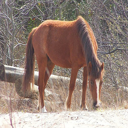

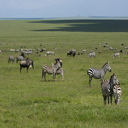

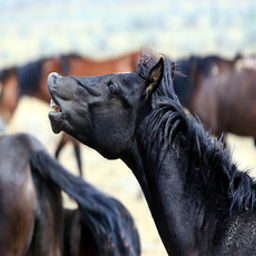

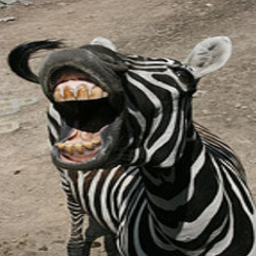

1190
200


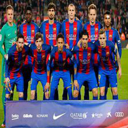

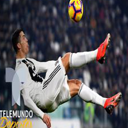

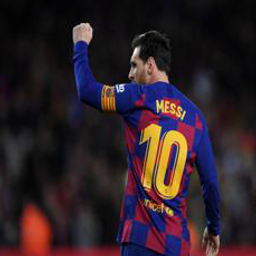

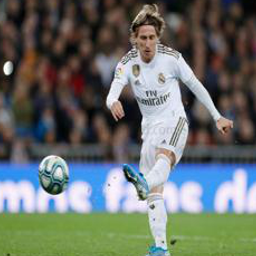

In [59]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

print(len(barcelona2madrid_train))
print(len(barcelona2madrid_test))

display_batch_images(barcelona2madrid_train[0][0])
display_batch_images(barcelona2madrid_train[0][1])
#
display_batch_images(barcelona2madrid_test[0][0])
display_batch_images(barcelona2madrid_test[0][1])

## Networks

Generator from Cycle GAN paper

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # ENCODING
        #self._encoder1 = self.encoder(3, 64, 4)
        #self._encoder2 = self.encoder(64, 128, 4)
        #self._encoder3 = self.encoder(128, 256, 4)
        self._encoder1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=0, bias=False),
            nn.BatchNorm2d(64),
            #nn.InstanceNorm2d(64),
            nn.ReLU(True)
        )
        self._encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            #nn.InstanceNorm2d(128),
            nn.ReLU(True)
        )
        self._encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            #nn.InstanceNorm2d(256),
            nn.ReLU(True)
        )

        # TRANSFORMATION (RESNET)
        out_channels = 256
        self._res1 = self.residual(out_channels, out_channels, 3)
        self._res2 = self.residual(out_channels, out_channels, 3)
        self._res3 = self.residual(out_channels, out_channels, 3)
        self._res4 = self.residual(out_channels, out_channels, 3)
        self._res5 = self.residual(out_channels, out_channels, 3)
        self._res6 = self.residual(out_channels, out_channels, 3)
        #self._res7 = self.residual(out_channels, out_channels, 3)
        #self._res8 = self.residual(out_channels, out_channels, 3)
        #self._res9 = self.residual(out_channels, out_channels, 3)

        # DECODING
        #self._decoder1 = self.decoder(256, 128, 4)
        #self._decoder2 = self.decoder(128, 64, 4)
        #self._decoder3 = self.decoder2(64, 3, 4)

        self._decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            #nn.InstanceNorm2d(128),
            nn.ReLU(True)
        )
        self._decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.InstanceNorm2d(64),
            nn.ReLU(True)
        )
        self._decoder3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5)
        )
        return x

    def residual(self, i, o, dim):
        #x = nn.Sequential(
        #    nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
        #    nn.BatchNorm2d(o),
        #    nn.LeakyReLU(0.2),
        #    nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
        #    nn.BatchNorm2d(o),
        #    nn.LeakyReLU(0.2)
        #)

        x = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(i, o, kernel_size=dim, padding=0, bias=False),
            nn.BatchNorm2d(o),
            #nn.InstanceNorm2d(o), 
            nn.ReLU(True),        
            nn.ReflectionPad2d(1),
            nn.Conv2d(i, o, kernel_size=dim, padding=0, bias=False),
            nn.BatchNorm2d(o),
            #nn.InstanceNorm2d(o), 
        )

        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5)
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=True),
            nn.Tanh()
        )
        return x 

    def forward(self, x):
        # Encode -> Transform -> Decode
        # Encoding
        x = self._encoder1(x)
        x = self._encoder2(x)
        x = self._encoder3(x)

        # Transformation: Resnet blocks
        a = x + self._res1(x)
        b = a + self._res2(a)
        c = b + self._res3(b)
        d = c + self._res4(c)
        e = d + self._res5(d)
        x = e + self._res6(e)
        #g = f + self._res7(f)
        #h = g + self._res8(g)
        #x = h + self._res9(h)

        # Decoding
        x = self._decoder1(x)
        x = self._decoder2(x)
        x = self._decoder3(x)

        return x

Discriminator from Cycle GAN paper

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            #nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            #nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            #nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=True),
            #nn.AdaptiveAvgPool2d(1)
        )

        #self._conv4 = nn.Sequential(
        #    nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
        #    #nn.BatchNorm2d(1),
        #    nn.LeakyReLU(0.2, inplace=True),
        #    nn.Sigmoid(),
        #    nn.AdaptiveAvgPool2d(1)
        #)

        # Global average pooling !!!
        # Global max pooling !!! (to avoid flatten and linear 4000 to 1)
        # self._fc1: 512 -> 128
        # self._fc2: 128 -> 1
        #self._avg_pool = nn.AdaptiveAvgPool2d(1)

        #self._fc = nn.Sequential(
        #    nn.Linear(int(256*image_size*image_size/(8*8)),1),
        #    #nn.LeakyReLU(0.2),
        #    #nn.Linear(1024,1),
        #    nn.Sigmoid()
        #)

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = self._conv4(x)
        output = self._conv5(x)
        #print(output.shape)

        #x = self._avg_pool(x).squeeze()
        #output = self._fc(x.view(-1, int(256*image_size*image_size/(8*8))))
        #output = self._fc(x)

        return output

## Model
Now lets create the core of our task, the model.  Remember Cycle GANs loss:
$\mathcal{L}_{GAN}(G,D_Y,X,Y)=\mathbb{E}_{y\sim p_{data}(y)}\big[logD_Y(y)\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[log(1-D_Y(G(x)))\big]$

$\mathcal{L}_{cyc}(G,F)=\mathbb{E}_{x\sim p_{data}(x)}\big[||F(G(x))-x||_1\big] + \mathbb{E}_{y\sim p_{data}(y)}\big[||G(F(y))-y||_1\big]$

The full objective is:

$\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y) + \mathcal{L}_{GAN}(F,D_X,Y,X) + \lambda\mathcal{L}_{cyc}(G,F)$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()

    def _create_optimizers(self):
        # generators optimizers
        # Look for param groups
        self._opt_gen = torch.optim.Adam(
            itertools.chain(self._generatorA2B.parameters(), self._generatorB2A.parameters()), lr=0.0002, betas=(0.5, 0.999)
        )

        # discriminators optimizers
        self._opt_discr = torch.optim.Adam(
            itertools.chain(self._discriminatorA.parameters(), self._discriminatorB.parameters()), lr=0.0002, betas=(0.5, 0.999)
        )
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss() # To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()  # L1 for Cycle Consistency Loss
        self._criterionIDT = nn.L1Loss()  # L1 for Identity Loss
        size_out = 14
        self._label_real = Variable(torch.ones(batch_size, 1, size_out, size_out)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1, size_out, size_out)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc, lambda_idt):
    
        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)
    
        idt_samplesA    = self._generatorA2B(real_samplesB)
        idt_samplesB    = self._generatorB2A(real_samplesA)

        cyc_samplesA    = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB    = self._generatorA2B(fake_samplesB2A)
    
        #
        # Optimize generators
        #
        # Reset gradients
        self._opt_gen.zero_grad()
    
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False
    
        estim_fakeA = self._discriminatorA(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorB(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA) * lambda_cyc
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB) * lambda_cyc
        #
        # Identity loss
        #
        loss_idtA = self._criterionIDT(idt_samplesA, real_samplesB) * lambda_idt
        loss_idtB = self._criterionIDT(idt_samplesB, real_samplesA) * lambda_idt
        #
        loss_g = loss_gA + loss_gB + loss_cycA + loss_cycB #+ loss_idtA + loss_idtB
        #
        loss_g.backward()
        self._opt_gen.step()

        #
        # Optimize discriminators
        #
        # Reset gradients
        self._opt_discr.zero_grad()

        # discriminators are updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = True
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        #
        # optimize discriminator A
        #  
        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesB)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)
    
        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesA2B.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)
    
        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        
        #
        # optimize discriminator B
        #
        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesA)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)
    
        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesB2A.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)
    
        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()

        self._opt_discr.step()
    
        return loss_gA.item(), loss_gB.item(), loss_dA.item(), loss_dB.item(), loss_cycA.item(), loss_cycB.item(), loss_idtA.item(), loss_idtB.item()

    def step_fake_samples(self, real_samplesA, real_samplesB):

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        idt_samplesA = self._generatorA2B(real_samplesB)
        idt_samplesB = self._generatorB2A(real_samplesA)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        return fake_samplesA2B, fake_samplesB2A, idt_samplesA, idt_samplesB, cyc_samplesA, cyc_samplesB

    def step_opt_generator(self, real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A, 
                           idt_samplesA, idt_samplesB, cyc_samplesA, cyc_samplesB, lambda_cyc, lambda_idt):

        # Reset gradients
        self._opt_gen.zero_grad()

        #
        # optimize generator A2B & B2A
        #
        with torch.no_grad():
          estim_fakeA = self._discriminatorB(fake_samplesA2B)
          estim_fakeB = self._discriminatorA(fake_samplesB2A)
        #
        # GAN loss
        #
        loss_gA = self._criterionGAN(estim_fakeA, True) #self._label_real)
        loss_gB = self._criterionGAN(estim_fakeB, True) #self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        #
        # Identity loss
        loss_idtA = self._criterionIDT(real_samplesB, idt_samplesA)
        loss_idtB = self._criterionIDT(real_samplesA, idt_samplesB)
        #
        # Total loss
        #
        loss_total = loss_gA + loss_gB + lambda_cyc*(loss_cycA + loss_cycB) + lambda_idt*(loss_idtA + loss_idtB)
        #
        loss_total.backward()
        self._opt_gen.step()

        return loss_gA.item(), loss_cycA.item(), loss_idtA.item(), loss_gB.item(), loss_cycB.item(), loss_idtB.item() 

    def step_opt_discriminator(self, real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A):

        # Reset gradients
        self._opt_discr.zero_grad()

        #
        # optimize discriminator A
        #
        # Calculate discriminator A loss for real samples B
        estim_realA = self._discriminatorA(real_samplesB)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples A2B
        estim_fakeA = self._discriminatorA(fake_samplesA2B.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        
        #
        # optimize discriminator B
        #
        # Calculate discriminator B loss for real samples A
        estim_realB = self._discriminatorB(real_samplesA)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples B2A
        estim_fakeB = self._discriminatorB(fake_samplesB2A.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()

        self._opt_discr.step()

        return loss_dA.item(), loss_dB.item()


## Train

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_epochs = 200
lambda_cyc = 10
lambda_idt = lambda_cyc * 0.5

model = Model(batch_size)
print(f"Number of parameters GeneratorA2B:   {count_parameters(model._generatorA2B)}")
print(f"Number of parameters GeneratorB2A:   {count_parameters(model._generatorB2A)}")
print(f"Number of parameters DiscriminatorA: {count_parameters(model._discriminatorA)}")
print(f"Number of parameters DiscriminatorB: {count_parameters(model._discriminatorB)}")


Number of parameters GeneratorA2B:   7841411
Number of parameters GeneratorB2A:   7841411
Number of parameters DiscriminatorA: 2765633
Number of parameters DiscriminatorB: 2765633


In [61]:
GA_loss = []
CYCA_loss = []
IDTA_loss = []
DA_loss = []
GB_loss = []
CYCB_loss = []
IDTB_loss = []
DB_loss = []
for epoch in range(num_epochs):
    epoch_time = time.time()
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA, loss_gB, loss_dA, loss_dB, loss_cycA, loss_cycB, loss_idtA, loss_idtB = model.step_optimization(
            real_samplesA, real_samplesB, lambda_cyc, lambda_idt)

        # Generate fake samples
        #fake_samplesA2B, fake_samplesB2A, idt_samplesA, idt_samplesB, cyc_samplesA, cyc_samplesB = model.step_fake_samples(
        #    real_samplesA, real_samplesB)

        # Optimize generators
        #if (n_batch) % k_gen == 0:
        #for i in range(k_gen):
        #  loss_gA, loss_cycA, loss_idtA, loss_gB, loss_cycB, loss_idtB = model.step_opt_generator(
        #      real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A, 
        #      idt_samplesA, idt_samplesB, cyc_samplesA, cyc_samplesB, lambda_cyc, lambda_idt)
        GA_loss.append(loss_gA)
        CYCA_loss.append(loss_cycA)
        IDTA_loss.append(loss_idtA)
        GB_loss.append(loss_gB)
        CYCB_loss.append(loss_cycB)
        IDTB_loss.append(loss_idtB)

        # Optimize discriminators
        #if (n_batch) % k_dis == 0:
        #for i in range(k_dis):
        #  loss_dA, loss_dB = model.step_opt_discriminator(real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A)
        DA_loss.append(loss_dA)
        DB_loss.append(loss_dB)
        
        # Adaptive lambda_cyc
        #if loss_cyc > 0.50:
        #  lambda_cyc = 5
        #elif loss_cyc < 0.50 and loss_cyc > 0.25:
        #  lambda_cyc = 2.5
        #elif loss_cyc < 0.25:
        #  lambda_cyc = 0.5

        # Show fake samples
        if n_batch == 10 and (epoch) % 5 == 0:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())
            #
            fake_samplesB = model._generatorB2A(real_samplesB)
            fake_samplesA = model._generatorA2B(fake_samplesB)
            display_batch_images(real_samplesB)
            display_batch_images(fake_samplesB.detach())
            display_batch_images(fake_samplesA.detach())

    # Show current loss
    #if (n_batch) % 100 == 0:
    print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch+1}/{len(data_loader_train)}")
    print(f"       GA_loss: {loss_gA}, DA_loss: {loss_dA}, CYCA_loss: {loss_cycA}, IDTA_loss: {loss_idtA}")
    print(f"       GB_loss: {loss_gB}, DB_loss: {loss_dB}, CYCB_loss: {loss_cycB}, IDTB_loss: {loss_idtB}")
    print(f"Time taken (s): {time.time()-epoch_time}")     


Output hidden; open in https://colab.research.google.com to view.

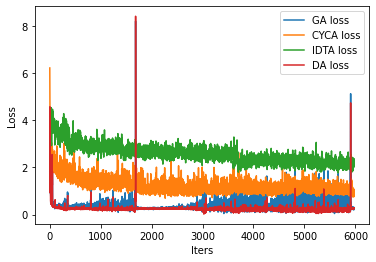

In [63]:
# Plot GAN loss
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Iters')
plt.plot(GA_loss, label='GA loss')
# Plot CYC loss
plt.plot(CYCA_loss, label='CYCA loss')
# Plot IDT loss
plt.plot(IDTA_loss, label='IDTA loss')
# Plot DISC loss
plt.plot(DA_loss, label='DA loss')
plt.legend()

# Plot DA loss
#plt.figure()
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.plot(DA_loss, label='dA loss')

# Plot DB loss
#plt.plot(DB_loss, label='dB loss')
#plt.legend()

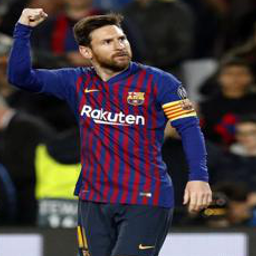

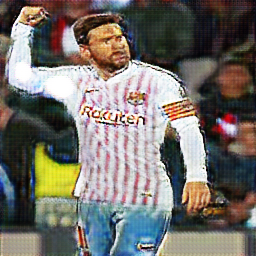

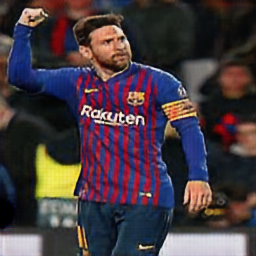

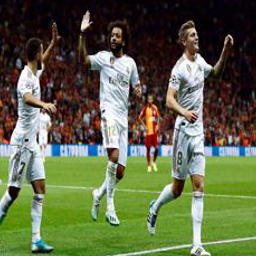

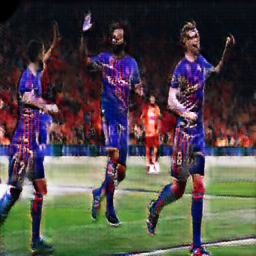

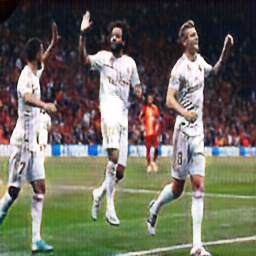

In [92]:
# Test example - 50 epochs
idx = 7
fake_samplesA = model._generatorA2B(barcelona2madrid_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(barcelona2madrid_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
idx = 18
fake_samplesB = model._generatorB2A(barcelona2madrid_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(barcelona2madrid_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


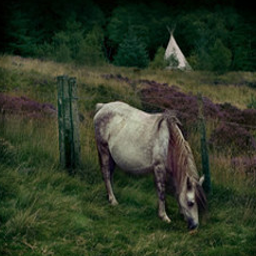

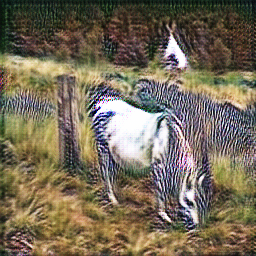

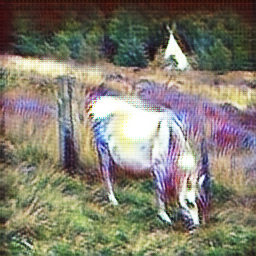

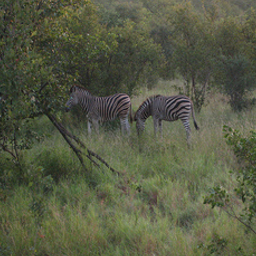

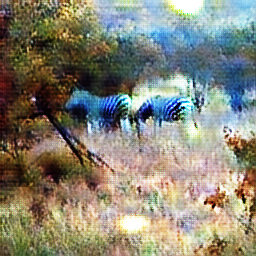

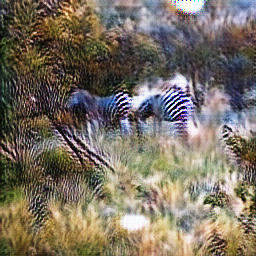

In [46]:
# Test example - 100 epochs - lambda = 1
idx = 1
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


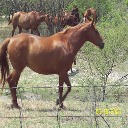

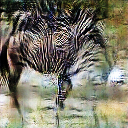

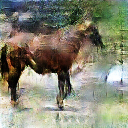

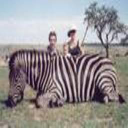

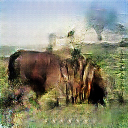

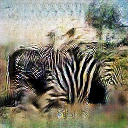

In [0]:
# Test example - 100 epochs - lambda = 2
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


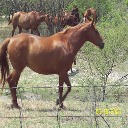

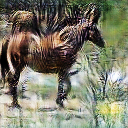

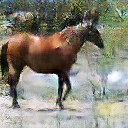

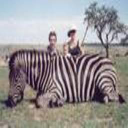

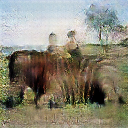

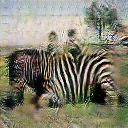

In [0]:
# Test example - 100 epochs - lambda = 5
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


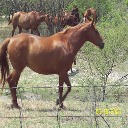

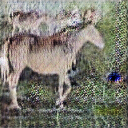

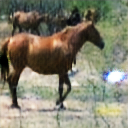

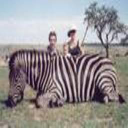

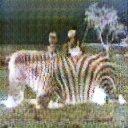

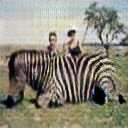

In [0]:
# Test example - 100 epochs - lambda = 10
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


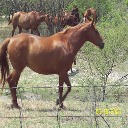

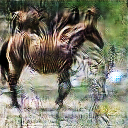

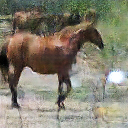

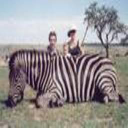

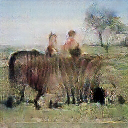

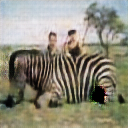

In [0]:
# Test example - 200 epochs - lambda adaptive
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


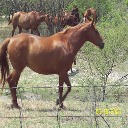

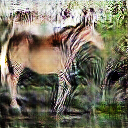

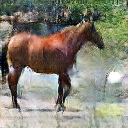

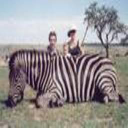

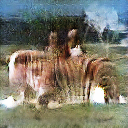

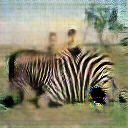

In [0]:
# Test example - 200 epochs - lambda adaptive - split training
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


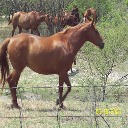

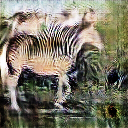

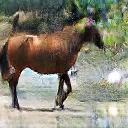

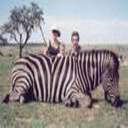

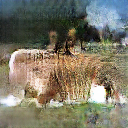

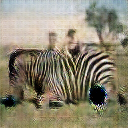

In [0]:
# Test example - 200 epochs - lambda adaptive - split training - randomhorizontalflip
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


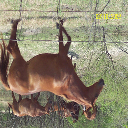

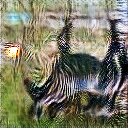

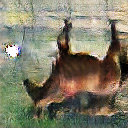

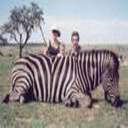

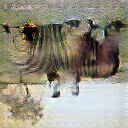

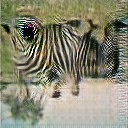

In [0]:
# Test example - 200 epochs - lambda adaptive - split training - 1/5 gen/disc
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


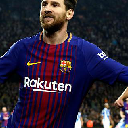

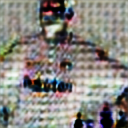

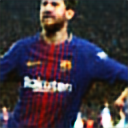

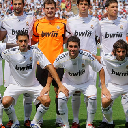

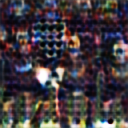

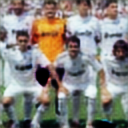

In [0]:
# Test example - 200 epochs - new architecture
idx = 3
fake_samplesA = model._generatorA2B(barcelona2madrid_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(barcelona2madrid_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
idx = 1
fake_samplesB = model._generatorB2A(barcelona2madrid_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(barcelona2madrid_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())
